In [1]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import cv2


from utils import *
from models.CtRNet import CtRNet



# Panda

In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.trained_on_multi_gpus = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/panda/panda-3cam_azure/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")

args.robot_name = 'Panda' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.height = 480
args.width = 640
args.fx, args.fy, args.px, args.py = 399.6578776041667, 399.4959309895833, 319.8955891927083, 244.0602823893229
args.scale = 0.5 # scale the input image size to (320,240)

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [3]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/panda/panda-3cam_azure/net.pth
Camera intrinsics: [[199.8289388    0.         159.9477946 ]
 [  0.         199.74796549 122.03014119]
 [  0.           0.           1.        ]]
Robot model: Panda


In [4]:
cv_img = cv2.imread(os.path.join(args.base_dir,"images/panda.jpg"))
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()

joint_angles = np.array([ 0.0200, -0.9641, -0.0662, -2.7979, -0.0469,  1.9289,  0.9137])

cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[[ 0.8575,  0.5139, -0.0044, -0.1976],
         [ 0.0952, -0.1674, -0.9811,  0.3963],
         [-0.5050,  0.8412, -0.1925,  1.0495],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


In [5]:
mesh_files = [base_dir + "/urdfs/Panda/meshes/visual/link0/link0.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link1/link1.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link2/link2.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link3/link3.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link4/link4.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link5/link5.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link6/link6.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link7/link7.obj",
              base_dir + "/urdfs/Panda/meshes/visual/hand/hand.obj",
             ]

robot_renderer = CtRNet.setup_robot_renderer(mesh_files)
robot_mesh = robot_renderer.get_robot_mesh(joint_angles)
rendered_image = CtRNet.render_single_robot_mask(cTr.squeeze(), robot_mesh, robot_renderer)

/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


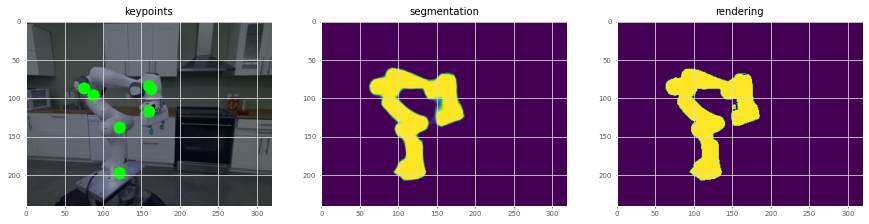

In [6]:
img_np = to_numpy_img(image)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("keypoints")
plt.imshow(img_np)
plt.subplot(1,3,2)
plt.title("segmentation")
plt.imshow(segmentation.squeeze().detach().cpu().numpy())
plt.subplot(1,3,3)
plt.title("rendering")
plt.imshow(rendered_image.squeeze().detach().cpu().numpy())
plt.show()